# Runnning

In [ ]:
%load_ext autoreload
%autoreload 2
from plot import *
import sys
sys.path.append("../lib")
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from matplotlib.colors import LinearSegmentedColormap
import sys 
import numpy as np
import jax
import jax.numpy as jnp
import jax
# jax.config.update("jax_platform_name", "cpu")
import matplotlib.pyplot as plt
rgb_values = [
    [231, 98, 84],
    [239, 138, 71],
    [247, 170, 88],
    [255, 208, 111],
    [255, 230, 183],
    [170, 220, 224],
    [114, 188, 213],
    [82, 143, 173],
    [55, 103, 149],
    # [30, 70, 110]
]
colors = [[x / 255 for x in rgb] for rgb in rgb_values]
colors_line = [
    (55/255, 103/255, 149/255),    # #c7522a
    (114/255, 188/255, 213/255),  # #e5c185
    (247/255, 170/255, 88/255),  # #fbf2c4
    (231/255, 98/255, 84/255)     # #008585
]
colors_line2 = [
    (189/255, 60/255, 51/255),    # #c7522a
    (63/255, 96/255, 163/255),  # #e5c185
]
plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "stix",
    "text.usetex": False,
    "figure.figsize": (8, 6),
    "axes.linewidth": 2.0,
    "font.size": 20,
    "axes.labelsize": 24,
    "axes.titlesize": 20,
    "legend.fontsize": 20,
    "xtick.labelsize": 20,    # tick label
    "ytick.labelsize": 20,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 8,
    "ytick.major.size": 8,
    "xtick.minor.size": 4,
    "ytick.minor.size": 4,
    "xtick.major.width": 2.0,
    "ytick.major.width": 2.0,
    "xtick.minor.width": 1.5,
    "ytick.minor.width": 1.5,
    "axes.labelpad": 6,
    "lines.linewidth": 1.5,
})
# plt.rcParams.update(params)
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=10)
cmap256 = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)
from notion_client import Client
notion = Client(auth="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")
database_id = "1f8fc9067a748057a9ebf052fd25a8bd"
response = notion.databases.query(
    database_id=database_id,
    page_size=100
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import os
import pickle
def save_pickle(obj, filename):
    """
    Save object to a pickle file
    """
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, "wb") as f:
        pickle.dump(obj, f)
    print(f"[Saved] {filename}")
def load_pickle(filename):
    """
    Load object from a pickle file
    """
    with open(filename, "rb") as f:
        obj = pickle.load(f)
    print(f"[Loaded] {filename}")
    return obj

In [18]:
all_results = load_pickle("SavedResults/all_results_non.pkl")
merged_by_axis_type = load_pickle("SavedResults/merged_by_axis_type.pkl")

[Loaded] SavedResults/all_results_non.pkl
[Loaded] SavedResults/merged_by_axis_type.pkl


In [19]:
all_results_mul = load_pickle("SavedResults/all_results.pkl")
merged_by_axis_type_mul = load_pickle("SavedResults/merged_by_axis_type_mul.pkl")

[Loaded] SavedResults/all_results.pkl
[Loaded] SavedResults/merged_by_axis_type_mul.pkl


In [20]:
def plot_all_systems_scatter_multi_ob_weighted_choose_whitebg(
    system_Rcusp_dicts,
    system_phi_dicts,
    system_weight_dicts,
    all_types,
    observation_list,
    output_path=None,
    show=True,
    max_points=None,
    notion_response=None,
    notion_rcusp_max=0.8,
    notion_axis_filter=None,
    cmap='magma',
    add_colorbar=True,
    grid_resolution=200,
    phi_min=30,
    phi_max=150,
    hide_ylabel=False
):
    # =========================================================
    #  [0] Imports
    # =========================================================
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    from scipy.ndimage import gaussian_filter
    import math
    # =============================
    # =============================
    # &&&!!!(20260107-1800) return plotted points for later sigma-region classification
    def _overlay_notion_points(ax, response, axis_filter=None):
        """
        Draw observational points from Notion:
        - marker: hollow black circle
        - with optional errorbars (phi_sigma, Rcusp_sigma)
        - apply axis_filter: "long" or "short"
        Returns
        -------
        plotted : list[dict]
            Each dict contains: name, phi, rcusp
        """
        from notion import get_lens_data_by_name, get_all_lens_names
        def _to_float_safe(x):
            try:
                if x is None:
                    return None
                return float(str(x).replace("±", "").strip())
            except (TypeError, ValueError):
                return None
        names = get_all_lens_names(response) or []
        plotted = []
        for name in names:
            d = get_lens_data_by_name(response, name)
            if not isinstance(d, dict):
                continue
            # --- read values ---
            phi         = _to_float_safe(d.get("phi"))
            rcusp       = _to_float_safe(d.get("Rcusp"))
            phi_sigma   = _to_float_safe(d.get("phi_sigma"))
            rcusp_sigma = _to_float_safe(d.get("Rcusp_sigma"))
            axis_type   = (d.get("axis_type") or "").strip().lower()
            # --- sanity checks ---
            if phi is None or rcusp is None:
                continue
            if not (math.isfinite(phi) and math.isfinite(rcusp)):
                continue
            if rcusp > notion_rcusp_max:
                continue
            if axis_type not in ("long", "short"):
                continue
            if axis_filter is not None and axis_type != axis_filter:
                continue
            # --- errorbar conditions ---
            has_xerr = (phi_sigma is not None) and math.isfinite(phi_sigma) and (phi_sigma > 0)
            has_yerr = (rcusp_sigma is not None) and math.isfinite(rcusp_sigma) and (rcusp_sigma > 0)
            # --- draw errorbar first (behind marker) ---
            if has_xerr or has_yerr:
                ax.errorbar(
                    phi, rcusp,
                    xerr=phi_sigma if has_xerr else None,
                    yerr=rcusp_sigma if has_yerr else None,
                    fmt="none",
                    ecolor="black",
                    elinewidth=2.6,
                    capsize=0,
                    alpha=0.95,
                    zorder=10
                )
            # --- draw hollow black circle ---
            ax.scatter(
                [phi], [rcusp],
                facecolors="none",
                edgecolors="black",
                marker="o",
                s=110,
                linewidths=1.5,
                alpha=0.98,
                zorder=6
            )
            plotted.append({"name": name, "phi": float(phi), "rcusp": float(rcusp)})
        return plotted
    # =========================================================
    #  [2] Global settings: range, bins, layout
    # =========================================================
    Rcusp_min, Rcusp_max = 0.0, notion_rcusp_max
    bin_width = 4.0
    phi_bins = np.arange(phi_min, phi_max + bin_width, bin_width)
    n_models = len(all_types)
    ncols = 4
    nrows = (n_models + ncols - 1) // ncols
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(6 * ncols, 6 * nrows),
        squeeze=False,
        facecolor="white",
    )
    phi_edges = phi_bins
    rcusp_edges = np.linspace(Rcusp_min, Rcusp_max, grid_resolution + 1)
    # --- density-to-alpha mapping ---
    threshold = 0.0
    fade_width = 0.05
    # =========================================================
    #  [2.5] HPD helpers (for 1σ/2σ/3σ contours)
    # =========================================================
    # &&&!!!(20260107-1800) add HPD/region helpers
    def _hpd_levels(P, masses=(0.683, 0.95, 0.997)):
        flat = P.ravel()
        order = np.argsort(flat)[::-1]
        cdf = np.cumsum(flat[order])
        levels = []
        for m in masses:
            idx = np.searchsorted(cdf, m)
            levels.append(flat[order[min(idx, flat.size - 1)]])
        # sort ascending for contour()
        return sorted(levels)
    def _classify_point_sigma(phi, rc, phi_edges, rc_edges, P_ct, levels_sorted):
        """
        Classify a point by HPD regions using density threshold:
        levels_sorted: ascending [3σ(th_low), 2σ, 1σ(th_high)].
        """
        bphi = np.digitize([phi], phi_edges)[0] - 1
        br   = np.digitize([rc],  rc_edges)[0] - 1
        if bphi < 0 or bphi >= P_ct.shape[0] or br < 0 or br >= P_ct.shape[1]:
            return "out-of-range"
        pval = P_ct[bphi, br]
        th_3 = levels_sorted[0]
        th_2 = levels_sorted[1]
        th_1 = levels_sorted[2]
        if pval >= th_1:
            return "inside 1σ (68.3%)"
        elif pval >= th_2:
            return "inside 2σ (95%)"
        elif pval >= th_3:
            return "inside 3σ (99.7%)"
        else:
            return "outside 3σ"
    # =========================================================
    #  [3] Per-model loop: collect -> histogram -> smooth -> normalize -> render
    # =========================================================
    for i, sim_type in enumerate(all_types):
        ax = axes[i // ncols][i % ncols]
        ax.set_facecolor("white")
        # -------------------------
        # (3.1) Collect arrays
        # -------------------------
        phi_all_deg_list = []
        Rcusp_all_list = []
        weight_all_list = []
        for Rcusp_dict, phi_dict, w_dict in zip(system_Rcusp_dicts, system_phi_dicts, system_weight_dicts):
            Rcusp_array = Rcusp_dict.get(sim_type, np.array([]))
            phi_array = phi_dict.get(sim_type, np.array([]))
            if Rcusp_array is None or phi_array is None:
                continue
            if np.size(Rcusp_array) == 0 or np.size(phi_array) == 0:
                continue
            w_array = w_dict.get(sim_type, None)
            if w_array is None or np.size(w_array) == 0:
                w_array = np.ones_like(Rcusp_array)
            Rcusp_array = np.asarray(Rcusp_array).ravel()
            phi_array = np.asarray(phi_array).ravel()
            w_array = np.asarray(w_array).ravel()
            n = min(Rcusp_array.size, phi_array.size, w_array.size)
            if n == 0:
                continue
            phi_all_deg_list.append(phi_array[:n])
            Rcusp_all_list.append(Rcusp_array[:n])
            weight_all_list.append(w_array[:n])
        if not Rcusp_all_list:
            ax.set_axis_off()
            continue
        phi_all_deg = np.concatenate(phi_all_deg_list)
        Rcusp_all = np.concatenate(Rcusp_all_list)
        w_all = np.concatenate(weight_all_list).astype(float)
        # -------------------------
        # (3.2) Weighted 2D histogram (for background shading)  [keep as-is]
        # -------------------------
        w_pos = np.clip(w_all, 0.0, None)
        if not np.any(w_pos > 0):
            w_pos = np.ones_like(w_all)
        H, _, _ = np.histogram2d(
            phi_all_deg, Rcusp_all,
            bins=[phi_edges, rcusp_edges],
            weights=w_pos
        )
        # -------------------------
        # (3.3) Smooth  [keep as-is]
        # -------------------------
        H_smooth = gaussian_filter(H, sigma=1.0)
        # -------------------------
        # (3.4) Normalize per phi-bin for background alpha-map  [keep as-is]
        # -------------------------
        norm_density_grid = np.zeros_like(H_smooth)
        for j in range(H_smooth.shape[0]):
            col = H_smooth[j]
            mask = col > 0
            if np.any(mask):
                cmin = col[mask].min()
                cmax = col[mask].max()
                if cmax > cmin:
                    norm_density_grid[j] = (col - cmin) / (cmax - cmin)
        # -------------------------
        # (3.5) Map to RGBA with alpha fade  [keep as-is]
        # -------------------------
        base_cmap = plt.get_cmap(cmap)
        rgba = base_cmap(norm_density_grid)
        alpha = np.zeros_like(norm_density_grid)
        higher = norm_density_grid >= (threshold + fade_width)
        mid = (norm_density_grid >= threshold) & (norm_density_grid < threshold + fade_width)
        alpha[higher] = 1.0
        alpha[mid] = (norm_density_grid[mid] - threshold) / fade_width
        rgba[..., 3] = alpha
        rgba_plot = np.transpose(rgba, (1, 0, 2))
        ax.imshow(
            rgba_plot,
            origin="lower",
            extent=[phi_min, phi_max, Rcusp_min, Rcusp_max],
            aspect="auto",
            interpolation="bilinear",
            zorder=1
        )
        # =========================================================
        # (3.5b) 1σ/2σ/3σ contours + sigma classification
        #        based on the SAME column-wise normalized grid (norm_density_grid)
        # =========================================================
        # &&&!!!(20260107-1935) HPD-like contours on column-normalized density (match background colors)
        def _hpd_levels_from_Z(Z, masses=(0.683, 0.95, 0.997)):
            """
            Z: non-negative 2D grid (here: norm_density_grid in [0,1] per-phi column).
            We treat Z/sum(Z) as a pseudo-probability to compute HPD-like thresholds.
            Returns
            -------
            levels_sorted : list[float] or None
                ascending thresholds [3σ, 2σ, 1σ]
            P_vis : 2D np.ndarray or None
                pseudo-probability grid (same shape as Z)
            """
            Z = np.asarray(Z, dtype=float)
            Z = np.clip(Z, 0.0, None)
            tot = Z.sum()
            if tot <= 0:
                return None, None
            P = Z / tot
            flat = P.ravel()
            order = np.argsort(flat)[::-1]
            cdf = np.cumsum(flat[order])
            levels = []
            for m in masses:
                idx = np.searchsorted(cdf, m)
                levels.append(flat[order[min(idx, flat.size - 1)]])
            return sorted(levels), P
        def _classify_point_sigma_from_P(phi, rc, phi_edges, rc_edges, P_grid, levels_sorted):
            """
            levels_sorted ascending: [3σ, 2σ, 1σ]
            """
            bphi = np.digitize([phi], phi_edges)[0] - 1
            br   = np.digitize([rc],  rc_edges)[0] - 1
            if bphi < 0 or bphi >= P_grid.shape[0] or br < 0 or br >= P_grid.shape[1]:
                return "out-of-range"
            pval = P_grid[bphi, br]
            th_3, th_2, th_1 = levels_sorted
            if pval >= th_1:
                return "inside 1σ (68.3%)"
            elif pval >= th_2:
                return "inside 2σ (95%)"
            elif pval >= th_3:
                return "inside 3σ (99.7%)"
            else:
                return "outside 3σ"
        # --- compute HPD-like thresholds from the SAME grid that drives the colors ---
        levels_sorted, P_vis = _hpd_levels_from_Z(norm_density_grid, masses=(0.683, 0.95, 0.997))
        if (levels_sorted is not None) and (P_vis is not None):
            phi_c = 0.5 * (phi_edges[:-1] + phi_edges[1:])
            rc_c  = 0.5 * (rcusp_edges[:-1] + rcusp_edges[1:])
            X, Y = np.meshgrid(phi_c, rc_c, indexing="xy")
            # background uses norm_density_grid with shape (nphi, nrc),
            # contour expects Z with shape (nrc, nphi) to match X,Y
            Z_vis = P_vis.T
            cs = ax.contour(
                X, Y, Z_vis,
                levels=levels_sorted,
                colors="black",
                linewidths=2.0,
                zorder=4
            )
            # 3σ most transparent -> 1σ least transparent
            alphas = [0.12, 0.24, 0.42]  # [3σ, 2σ, 1σ]
            for coll, a in zip(cs.collections, alphas):
                coll.set_alpha(a)
        else:
            levels_sorted = None
            P_vis = None
        # -------------------------
        # (3.6) Overlay observations + print sigma region (based on the SAME P_vis)
        # -------------------------
        plotted_obs = []
        if notion_response is not None:
            plotted_obs = _overlay_notion_points(ax, notion_response, axis_filter=notion_axis_filter)
        if plotted_obs and (P_vis is not None) and (levels_sorted is not None):
            print(f"\n[{sim_type}] Notion points sigma-region classification (column-normalized HPD-like):")
            for item in plotted_obs:
                region = _classify_point_sigma_from_P(
                    item["phi"], item["rcusp"],
                    phi_edges, rcusp_edges,
                    P_vis, levels_sorted
                )
                print(f"  - {item['name']}: {region}")
        elif plotted_obs:
            print(f"\n[{sim_type}] Notion points: (no valid visual-HPD grid -> cannot classify)")
        # -------------------------
        # (3.7) Labels & axes style
        # -------------------------
        ax.text(
            phi_max - 5,
            Rcusp_max - 0.025,
            sim_type,
            fontsize=24,
            ha="right",
            va="top",
            color="black"
        )
        ax.set_xlim(phi_min, phi_max)
        ax.set_ylim(Rcusp_min, Rcusp_max)
        if hide_ylabel and i > 0:
            ax.set_ylabel("")
            ax.set_yticks([])
        else:
            ax.set_ylabel("$R_{cusp}$", color="black", fontsize=24)
        ax.set_xlabel(r"$\phi$", color="black", fontsize=24)
        ax.tick_params(colors="black")
    # =========================================================
    #  [4] Clean empty subplots + layout + save/show
    # =========================================================
    for idx in range(n_models, nrows * ncols):
        fig.delaxes(axes[idx // ncols][idx % ncols])
    plt.tight_layout(rect=[0, 0, 0.955, 0.95])
    if output_path:
        plt.savefig(output_path, dpi=300, facecolor="white")
    if show:
        plt.show()
    else:
        plt.close()

# Direct contour plot

In [123]:
def plot_all_systems_scatter_multi_ob_weighted_choose_whitebg(
    system_Rcusp_dicts,
    system_phi_dicts,
    system_weight_dicts,
    all_types,
    observation_list,
    output_path=None,
    show=True,
    max_points=None,
    notion_response=None,
    notion_rcusp_max=0.8,
    notion_axis_filter=None,
    cmap='magma',
    add_colorbar=True,
    grid_resolution=200,
    phi_min=30,
    phi_max=150,
    hide_ylabel=False
):
    # =========================================================
    #  [0] Imports
    # =========================================================
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    from scipy.ndimage import gaussian_filter
    import math
    # =============================
    # =============================
    # &&&!!!(20260107-1800) return plotted points for later sigma-region classification
    def _overlay_notion_points(ax, response, axis_filter=None):
        """
        Draw observational points from Notion:
        - marker: hollow black circle
        - with optional errorbars (phi_sigma, Rcusp_sigma)
        - apply axis_filter: "long" or "short"
        Returns
        -------
        plotted : list[dict]
            Each dict contains: name, phi, rcusp
        """
        from notion import get_lens_data_by_name, get_all_lens_names
        def _to_float_safe(x):
            try:
                if x is None:
                    return None
                return float(str(x).replace("±", "").strip())
            except (TypeError, ValueError):
                return None
        names = get_all_lens_names(response) or []
        plotted = []
        for name in names:
            d = get_lens_data_by_name(response, name)
            if not isinstance(d, dict):
                continue
            # --- read values ---
            phi         = _to_float_safe(d.get("phi"))
            rcusp       = _to_float_safe(d.get("Rcusp"))
            phi_sigma   = _to_float_safe(d.get("phi_sigma"))
            rcusp_sigma = _to_float_safe(d.get("Rcusp_sigma"))
            axis_type   = (d.get("axis_type") or "").strip().lower()
            # --- sanity checks ---
            if phi is None or rcusp is None:
                continue
            if not (math.isfinite(phi) and math.isfinite(rcusp)):
                continue
            if rcusp > notion_rcusp_max:
                continue
            if axis_type not in ("long", "short"):
                continue
            if axis_filter is not None and axis_type != axis_filter:
                continue
            # --- errorbar conditions ---
            has_xerr = (phi_sigma is not None) and math.isfinite(phi_sigma) and (phi_sigma > 0)
            has_yerr = (rcusp_sigma is not None) and math.isfinite(rcusp_sigma) and (rcusp_sigma > 0)
            # --- draw errorbar first (behind marker) ---
            if has_xerr or has_yerr:
                ax.errorbar(
                    phi, rcusp,
                    xerr=phi_sigma if has_xerr else None,
                    yerr=rcusp_sigma if has_yerr else None,
                    fmt="none",
                    ecolor="black",
                    elinewidth=2.6,
                    capsize=0,
                    alpha=0.95,
                    zorder=10
                )
            # --- draw hollow black circle ---
            ax.scatter(
                [phi], [rcusp],
                facecolors="none",
                edgecolors="black",
                marker="o",
                s=110,
                linewidths=1.5,
                alpha=0.98,
                zorder=6
            )
            plotted.append({"name": name, "phi": float(phi), "rcusp": float(rcusp)})
        return plotted
    # =========================================================
    #  [2] Global settings: range, bins, layout
    # =========================================================
    Rcusp_min, Rcusp_max = 0.0, notion_rcusp_max
    bin_width = 4.0
    phi_bins = np.arange(phi_min, phi_max + bin_width, bin_width)
    n_models = len(all_types)
    ncols = 4
    nrows = (n_models + ncols - 1) // ncols
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(6 * ncols, 6 * nrows),
        squeeze=False,
        facecolor="white",
    )
    phi_edges = phi_bins
    rcusp_edges = np.linspace(Rcusp_min, Rcusp_max, grid_resolution + 1)
    # --- density-to-alpha mapping ---
    threshold = 0.0
    fade_width = 0.05
    # =========================================================
    #  [3] Per-model loop: collect -> histogram -> smooth -> normalize -> render
    # =========================================================
    for i, sim_type in enumerate(all_types):
        ax = axes[i // ncols][i % ncols]
        ax.set_facecolor("white")
        # -------------------------
        # (3.1) Collect arrays
        # -------------------------
        phi_all_deg_list = []
        Rcusp_all_list = []
        weight_all_list = []
        for Rcusp_dict, phi_dict, w_dict in zip(system_Rcusp_dicts, system_phi_dicts, system_weight_dicts):
            Rcusp_array = Rcusp_dict.get(sim_type, np.array([]))
            phi_array = phi_dict.get(sim_type, np.array([]))
            if Rcusp_array is None or phi_array is None:
                continue
            if np.size(Rcusp_array) == 0 or np.size(phi_array) == 0:
                continue
            w_array = w_dict.get(sim_type, None)
            if w_array is None or np.size(w_array) == 0:
                w_array = np.ones_like(Rcusp_array)
            Rcusp_array = np.asarray(Rcusp_array).ravel()
            phi_array = np.asarray(phi_array).ravel()
            w_array = np.asarray(w_array).ravel()
            n = min(Rcusp_array.size, phi_array.size, w_array.size)
            if n == 0:
                continue
            phi_all_deg_list.append(phi_array[:n])
            Rcusp_all_list.append(Rcusp_array[:n])
            weight_all_list.append(w_array[:n])
        if not Rcusp_all_list:
            ax.set_axis_off()
            continue
        phi_all_deg = np.concatenate(phi_all_deg_list)
        Rcusp_all = np.concatenate(Rcusp_all_list)
        w_all = np.concatenate(weight_all_list).astype(float)
        # =========================================================
        # (3.2~3.6) Build norm_density_grid (per-phi-bin min-max) -> draw with contourf
        #           + thin internal lines + HPD-like sigma contours on the SAME grid
        # =========================================================
        # &&&!!!(20260107-2105) unified: everything based on norm_density_grid (per-phi-bin min-max)
        # ---- weights (non-negative) ----
        w_pos = np.clip(w_all, 0.0, None)
        if not np.any(w_pos > 0):
            w_pos = np.ones_like(w_all)
        # ---- weighted histogram (phi x rcusp) ----
        H, _, _ = np.histogram2d(
            phi_all_deg, Rcusp_all,
            bins=[phi_edges, rcusp_edges],
            weights=w_pos
        )
        H = gaussian_filter(H, sigma=1.0)
        H = np.clip(H, 0.0, None)
        if H.sum() <= 0:
            ax.set_axis_off()
            continue
        # ---- per-phi-bin MIN-MAX normalization to [0,1] (this is your norm_density_grid) ----
        norm_density_grid = np.zeros_like(H)
        for j in range(H.shape[0]):          # j loops over phi bins
            col = H[j]                       # col over rcusp bins
            mask = col > 0
            if np.any(mask):
                cmin = col[mask].min()
                cmax = col[mask].max()
                if cmax > cmin:
                    norm_density_grid[j] = (col - cmin) / (cmax - cmin)
        # ---- grid for contour plotting ----
        phi_c = 0.5 * (phi_edges[:-1] + phi_edges[1:])
        rc_c  = 0.5 * (rcusp_edges[:-1] + rcusp_edges[1:])
        X, Y = np.meshgrid(phi_c, rc_c, indexing="xy")
        Z_bg = norm_density_grid.T  # (nrc, nphi)
        # ---- background shading (NO imshow, no blocks) ----
        ax.contourf(
            X, Y, Z_bg,
            levels=50,
            cmap=cmap,
            alpha=0.50,
            zorder=1
        )
        # =========================================================
        # HPD-like sigma contours based on norm_density_grid (your method)
        # =========================================================
        def _hpd_levels_from_Z(Z, masses=(0.683, 0.95, 0.997)):
            Z = np.asarray(Z, dtype=float)
            Z = np.clip(Z, 0.0, None)
            tot = Z.sum()
            if tot <= 0:
                return None, None
            P = Z / tot
            flat = P.ravel()
            order = np.argsort(flat)[::-1]
            cdf = np.cumsum(flat[order])
            levels = []
            for m in masses:
                idx = np.searchsorted(cdf, m)
                levels.append(flat[order[min(idx, flat.size - 1)]])
            return sorted(levels), P  # ascending: [3σ, 2σ, 1σ], and P grid
        def _classify_point_sigma_from_P(phi, rc, phi_edges, rc_edges, P_grid, levels_sorted):
            bphi = np.digitize([phi], phi_edges)[0] - 1
            br   = np.digitize([rc],  rcusp_edges)[0] - 1
            if bphi < 0 or bphi >= P_grid.shape[0] or br < 0 or br >= P_grid.shape[1]:
                return "out-of-range"
            pval = P_grid[bphi, br]
            th_3, th_2, th_1 = levels_sorted
            if pval >= th_1:
                return "inside 1σ (68.3%)"
            elif pval >= th_2:
                return "inside 2σ (95%)"
            elif pval >= th_3:
                return "inside 3σ (99.7%)"
            else:
                return "outside 3σ"
        levels_sorted, P_vis = _hpd_levels_from_Z(norm_density_grid, masses=(0.683, 0.95, 0.997))
        if (levels_sorted is not None) and (P_vis is not None):
            Z_sig = P_vis.T  # contour expects (nrc, nphi)
            # cs = ax.contour(
            #     X, Y, Z_sig,
            #     levels=levels_sorted,
            #     colors="black",
            #     linewidths=2.2,
            #     zorder=4
            # )
            # # 3σ most transparent -> 1σ least transparent
            # alphas = [0.12, 0.24, 0.42]  # [3σ, 2σ, 1σ]
            # for coll, a in zip(cs.collections, alphas):
            #     coll.set_alpha(a)
            # === sigma contours: color follows the background colormap ===
            cm = plt.get_cmap(cmap)
            norm = mcolors.Normalize(vmin=np.nanmin(Z_sig), vmax=np.nanmax(Z_sig))
            offset = 0.05
            line_colors = [
                cm(np.clip(norm(lv) + offset, 0, 1))
                for lv in levels_sorted
            ]
            cs = ax.contour(
                X, Y, Z_sig,
                levels=levels_sorted,
                colors=line_colors,
                zorder=4
            )
            linewidths = [4.0, 4.0, 4.0]   # [3σ, 2σ, 1σ]
            for coll, lw in zip(cs.collections, linewidths):
                coll.set_linewidth(lw)
                coll.set_alpha(1.0)
        # ---- overlay notion + print sigma region using SAME P_vis ----
        plotted_obs = []
        if notion_response is not None:
            plotted_obs = _overlay_notion_points(ax, notion_response, axis_filter=notion_axis_filter)
        if plotted_obs and (P_vis is not None) and (levels_sorted is not None):
            print(f"\n[{sim_type}] Notion points sigma-region classification (per-phi min-max normalized):")
            for item in plotted_obs:
                region = _classify_point_sigma_from_P(
                    item["phi"], item["rcusp"],
                    phi_edges, rcusp_edges,
                    P_vis, levels_sorted
                )
                print(f"  - {item['name']}: {region}")
        elif plotted_obs:
            print(f"\n[{sim_type}] Notion points: (no valid norm-grid -> cannot classify)")
        # -------------------------
        # Axis labels & ticks
        # -------------------------
        ax.set_xlim(phi_min, phi_max)
        ax.set_ylim(Rcusp_min, Rcusp_max)
        ax.set_xlabel(r"$\phi$")
        if hide_ylabel and i > 0:
            ax.set_ylabel("")
            ax.set_yticks([])
        else:
            ax.set_ylabel(r"$R_{\rm cusp}$",)
        ax.tick_params()
        
    # =========================================================
    #  [4] Clean empty subplots + layout + save/show
    # =========================================================
    for idx in range(n_models, nrows * ncols):
        fig.delaxes(axes[idx // ncols][idx % ncols])
    plt.tight_layout(rect=[0, 0, 0.955, 0.95])
    if output_path:
        plt.savefig(output_path, dpi=300, facecolor="white")
    if show:
        plt.show()
    else:
        plt.close()

## Merge two plots

In [21]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
def plot_rcusp_phi_combined_two_axes_hpd2sigma(
    merged_by_axis_type,          # {"short_axis": {...}, "long_axis": {...}}
    notion_response=None,
    output_path=None,
    show=True,
    notion_rcusp_max=0.8,
    cmap="magma",
    grid_resolution=50,
    phi_max=150,
    phi_min_short=60,
    phi_min_long=30,
    bin_width=4.0,
    smooth_sigma=1.0,
    masses=(0.683, 0.95, 0.997),
    bg_alpha=0.50,
    add_colorbar=True,
    mark_outside_2sigma=True,
    outlier_color="#FE624E",
    outlier_lw=3,
    # ============================================================
    # ============================================================
    sigma_label_phi=None,
    sigma_fontsize=24,
    sigma_rotation=0,
    subtex = None
):
    """
    2x3:
      Row0: long_axis  -> Major-axis
      Row1: short_axis -> Minor-axis
      Cols: CDM, SIDM, FDM
    Notion points: black hollow circles with error bars; >2σ (95%) get an outlier ring and matching label.
    2σ threshold based on HPD-like levels from norm_density_grid (P-grid).
    """
    import matplotlib.patheffects as pe
    sim_type_list = ["CDM", "SIDM", "FDM"]
    Rcusp_min, Rcusp_max = 0.0, notion_rcusp_max
    # ============================================================
    # ============================================================
    def _build_edges(phi_min_local):
        phi_edges = np.arange(phi_min_local, phi_max + bin_width, bin_width)
        rcusp_edges = np.linspace(Rcusp_min, Rcusp_max, grid_resolution + 1)
        return phi_edges, rcusp_edges
    def _collect_model_points(sim_dict, sim_type):
        R = np.asarray(sim_dict.get(sim_type, {}).get("Rcusp", np.array([]))).ravel()
        P = np.asarray(sim_dict.get(sim_type, {}).get("phi",   np.array([]))).ravel()
        W = np.asarray(sim_dict.get(sim_type, {}).get("w",     np.array([]))).ravel()
        if R.size == 0 or P.size == 0:
            return None, None, None
        n = min(R.size, P.size)
        R = R[:n]
        P = P[:n]
        if W.size != n:
            W = np.ones_like(R, dtype=float)
        else:
            W = W[:n].astype(float)
        return P, R, W
    def _compute_norm_density_grid(phi, rcusp, w, phi_edges, rcusp_edges):
        """
        Normalization per φ bin is defined here:
        Currently using per-φ-bin min-max on Rcusp to [0,1]
        """
        w_pos = np.clip(w, 0.0, None)
        if not np.any(w_pos > 0):
            w_pos = np.ones_like(w_pos)
        H, _, _ = np.histogram2d(phi, rcusp, bins=[phi_edges, rcusp_edges], weights=w_pos)
        H = gaussian_filter(H, sigma=smooth_sigma)
        H = np.clip(H, 0.0, None)
        if H.sum() <= 0:
            return None
        norm = np.zeros_like(H)
        for j in range(H.shape[0]):  # phi bins
            col = H[j]
            mask = col > 0
            if np.any(mask):
                cmin = col[mask].min()
                cmax = col[mask].max()
                if cmax > cmin:
                    norm[j] = (col - cmin) / (cmax - cmin)
        return norm  # (n_phi_bins-1, n_rcusp_bins-1)
    def _hpd_levels_from_Z(Z, masses=(0.683, 0.95, 0.997)):
        Z = np.asarray(Z, dtype=float)
        Z = np.clip(Z, 0.0, None)
        tot = Z.sum()
        if tot <= 0:
            return None, None
        P = Z / tot
        flat = P.ravel()
        order = np.argsort(flat)[::-1]
        cdf = np.cumsum(flat[order])
        levels = []
        for m in masses:
            idx = np.searchsorted(cdf, m)
            levels.append(flat[order[min(idx, flat.size - 1)]])
        return sorted(levels), P  # ascending: [3σ,2σ,1σ]
    def _bin_index(phi, rc, phi_edges, rc_edges, P_grid):
        bphi = np.searchsorted(phi_edges, phi, side="right") - 1
        br   = np.searchsorted(rc_edges,  rc,  side="right") - 1
        if bphi < 0 or br < 0:
            return None
        if bphi >= P_grid.shape[0] or br >= P_grid.shape[1]:
            return None
        return bphi, br
    def _to_float_safe(x):
        try:
            if x is None:
                return None
            return float(str(x).replace("±", "").strip())
        except (TypeError, ValueError):
            return None
    # ============================================================
    # ============================================================
    def _overlay_notion_points_and_mark_2sigma(
        ax, axis_filter, phi_edges, rc_edges, P_grid, levels_sorted, phi_min_local
    ):
        """
         Notion (+),  2σ  outlier_color  + . 
        Returns: sigma  artists(++outlier ring)
        """
        if notion_response is None:
            return []
        from notion import get_lens_data_by_name, get_all_lens_names
        # levels_sorted ascending: [3σ, 2σ, 1σ]
        th_2sigma = None
        if (levels_sorted is not None) and (len(levels_sorted) >= 2):
            th_2sigma = levels_sorted[1]
        placed_texts = []
        avoid_artists = []
        def _clamp_text_pos(x, y, phi_min_local, phi_max_local, pad_x=5.0, pad_y=0.03):
            x = min(max(x, phi_min_local + pad_x), phi_max_local - pad_x)
            y = min(max(y, Rcusp_min + pad_y), Rcusp_max - pad_y)
            return x, y
        def _repel_text_pos(x, y, placed, repel_dx=10.0, repel_dy=0.04, step_y=0.04, max_tries=18):
            for _ in range(max_tries):
                ok = True
                for (px, py) in placed:
                    if abs(x - px) < repel_dx and abs(y - py) < repel_dy:
                        ok = False
                        break
                if ok:
                    break
                y += step_y
            return x, y
        names = get_all_lens_names(notion_response) or []
        for name in names:
            d = get_lens_data_by_name(notion_response, name)
            if not isinstance(d, dict):
                continue
            phi         = _to_float_safe(d.get("phi"))
            rcusp       = _to_float_safe(d.get("Rcusp"))
            phi_sigma   = _to_float_safe(d.get("phi_sigma"))
            rcusp_sigma = _to_float_safe(d.get("Rcusp_sigma"))
            axis_type   = (d.get("axis_type") or "").strip().lower()
            if phi is None or rcusp is None:
                continue
            if not (math.isfinite(phi) and math.isfinite(rcusp)):
                continue
            if rcusp > notion_rcusp_max:
                continue
            if axis_type not in ("long", "short"):
                continue
            if axis_filter is not None and axis_type != axis_filter:
                continue
            has_xerr = (phi_sigma is not None) and math.isfinite(phi_sigma) and (phi_sigma > 0)
            has_yerr = (rcusp_sigma is not None) and math.isfinite(rcusp_sigma) and (rcusp_sigma > 0)
            if has_xerr or has_yerr:
                eb = ax.errorbar(
                    phi, rcusp,
                    xerr=phi_sigma if has_xerr else None,
                    yerr=rcusp_sigma if has_yerr else None,
                    fmt="none",
                    ecolor="black",
                    elinewidth=2.0,
                    capsize=0,
                    alpha=1,
                    zorder=10
                )
                avoid_artists.append(eb)
            # black hollow
            sc = ax.scatter(
                [phi], [rcusp],
                facecolors="none",
                edgecolors="black",
                marker="o",
                s=90,
                linewidths=1.5,
                alpha=1,
                zorder=11
            )
            avoid_artists.append(sc)
            # outside 2σ?
            if (mark_outside_2sigma and (P_grid is not None) and (th_2sigma is not None) and math.isfinite(th_2sigma)):
                idx = _bin_index(phi, rcusp, phi_edges, rc_edges, P_grid)
                if idx is None:
                    continue
                bphi, br = idx
                pval = float(P_grid[bphi, br])
                if pval < th_2sigma:
                    # outlier ring (also avoid)
                    sc_out = ax.scatter(
                        [phi], [rcusp],
                        facecolors="none",
                        edgecolors=outlier_color,
                        marker="o",
                        s=90,
                        linewidths=outlier_lw,
                        alpha=1.0,
                        zorder=20
                    )
                    avoid_artists.append(sc_out)
                    # outlier label
                    nm = str(name).strip()
                    x_text = phi + 4.0
                    y_text = rcusp + 0.02
                    ha = "left"
                    if x_text > (phi_max - 6.0):
                        x_text = phi - 4.0
                        ha = "right"
                    x_text, y_text = _clamp_text_pos(x_text, y_text, phi_min_local, phi_max)
                    x_text, y_text = _repel_text_pos(x_text, y_text, placed_texts)
                    t = ax.text(
                        x_text, y_text, nm,
                        color=outlier_color,
                        fontsize=20,
                        ha=ha,
                        fontweight="bold",
                        va="center",
                        zorder=13,
                        clip_on=True
                    )
                    t.set_path_effects([pe.withStroke(linewidth=1.5, foreground="white")])
                    placed_texts.append((x_text, y_text))
        return avoid_artists
    # ============================================================
    # ============================================================
    def _get_phi_target(axis_filter, sim_type, which_sigma, phi_min_local):
        default_phi = 0.5 * (phi_min_local + phi_max)
        if not isinstance(sigma_label_phi, dict):
            return default_phi
        row = sigma_label_phi.get(axis_filter, {})
        panel = row.get(sim_type, {})
        val = panel.get(which_sigma, None)
        try:
            return float(val) if val is not None else default_phi
        except Exception:
            return default_phi
    def _find_point_near_phi_on_level(cs, phi_target, prefer="top", x_window=2.0):
        """
        Choose manual points per single-level contour (scan all segments, not just the longest): 
        - For each segment: find candidates near the min dx (dx <= min_dx + x_window)
        - prefer="top": pick the candidate with the largest y
        prefer="bottom": pick the candidate with the smallest y
        """
        if cs is None or (not hasattr(cs, "levels")) or len(cs.levels) == 0:
            return None
        if not hasattr(cs, "allsegs") or len(cs.allsegs) == 0:
            return None
        segs = cs.allsegs[0]
        if segs is None or len(segs) == 0:
            return None
        best = None  # (x, y)
        best_y = None
        for seg in segs:
            if seg is None or seg.shape[0] < 2:
                continue
            dx = np.abs(seg[:, 0] - phi_target)
            min_dx = float(dx.min())
            mask = dx <= (min_dx + float(x_window))
            cand = seg[mask]
            if cand.shape[0] == 0:
                continue
            if prefer == "bottom":
                k = int(np.argmin(cand[:, 1]))
            else:
                k = int(np.argmax(cand[:, 1]))
            xy = (float(cand[k, 0]), float(cand[k, 1]))
            # Then choose the global top/bottom across segments
            if best is None:
                best = xy
                best_y = xy[1]
            else:
                if prefer == "bottom":
                    if xy[1] < best_y:
                        best, best_y = xy, xy[1]
                else:
                    if xy[1] > best_y:
                        best, best_y = xy, xy[1]
        return best
    def _place_sigma_label_on_single_cs(ax, cs_single, label_text, phi_target, color, fontsize, debug=False):
        """
        Call clabel(inline=True) only once for each single-level cs_single: 
        -  IndexError(csclabel)
        """
        import matplotlib.patheffects as pe
        if cs_single is None or (not hasattr(cs_single, "levels")) or len(cs_single.levels) == 0:
            if debug:
                print("[SigmaLabel] empty cs_single:", label_text)
            return
        level_exact = float(cs_single.levels[0])
        best_xy = _find_point_near_phi_on_level(cs_single, phi_target, prefer="top", x_window=2.0)
        if debug:
            print(f"[SigmaLabel] {label_text}: level={level_exact:.6g}, phi_target={phi_target:.2f}, best_xy={best_xy}")
        if best_xy is None:
            return
        try:
            texts = ax.clabel(
                cs_single,
                levels=[level_exact],
                inline=True,
                inline_spacing=10,
                manual=[best_xy],
                fmt={level_exact: label_text},
                fontsize=fontsize,
                # colors=[color],
                colors = 'k',
                zorder=6
            )
            for t in texts:
                t.set_fontweight("bold")
                t.set_rotation(sigma_rotation)
                # t.set_path_effects([pe.withStroke(linewidth=1.5, foreground="k")])
        except Exception as e:
            if debug:
                print(f"[SigmaLabel] {label_text} clabel ERROR: {type(e).__name__}: {e}")
            t = ax.text(
                best_xy[0], best_xy[1],
                label_text,
                color=color,
                fontsize=fontsize,
                fontweight="bold",
                ha="center", va="center",
                rotation=sigma_rotation,
                zorder=6,
                clip_on=True
            )
            t.set_path_effects([pe.withStroke(linewidth=1.5, foreground="white")])
    # ============================================================
    # [Block 4] Figure layout
    # ============================================================
    fig = plt.figure(figsize=(18, 12), facecolor="white")
    gs = fig.add_gridspec(2, 4, width_ratios=[1.0, 1.0, 1.0, 0.06], wspace=0.1, hspace=0.1)
    axes = np.empty((2, 3), dtype=object)
    for rr in range(2):
        for cc in range(3):
            axes[rr, cc] = fig.add_subplot(gs[rr, cc])
    cax = fig.add_subplot(gs[:, 3]) if add_colorbar else None
    base_cmap = plt.get_cmap(cmap) if isinstance(cmap, str) else cmap
    sm = plt.cm.ScalarMappable(cmap=base_cmap, norm=plt.Normalize(vmin=0.0, vmax=1.0))
    sm.set_array([])
    row_keys = [
        ("long_axis",  "long",  phi_min_long,  "Major-axis"),
        ("short_axis", "short", phi_min_short, "Minor-axis"),
    ]
    # ============================================================
    # [Block 5] Main loop
    # ============================================================
    for r, (axis_key, axis_filter, phi_min_local, axis_tag) in enumerate(row_keys):
        sim_dict = merged_by_axis_type.get(axis_key, {})
        for c, sim_type in enumerate(sim_type_list):
            ax = axes[r, c]
            ax.set_facecolor("white")
            phi, rcusp, w = _collect_model_points(sim_dict, sim_type)
            if phi is None:
                ax.set_axis_off()
                continue
            phi_edges, rc_edges = _build_edges(phi_min_local)
            norm_grid = _compute_norm_density_grid(phi, rcusp, w, phi_edges, rc_edges)
            if norm_grid is None:
                ax.set_axis_off()
                continue
            # background
            phi_c = 0.5 * (phi_edges[:-1] + phi_edges[1:])
            rc_c  = 0.5 * (rc_edges[:-1] + rc_edges[1:])
            X, Y = np.meshgrid(phi_c, rc_c, indexing="xy")
            ax.imshow(
                norm_grid.T,
                origin="lower",
                extent=[phi_c.min(), phi_c.max(), rc_c.min(), rc_c.max()],
                cmap=base_cmap,
                alpha=bg_alpha,
                aspect="auto",
                zorder=1,
                interpolation="bilinear"
            )
            # HPD levels
            levels_sorted, P_grid = _hpd_levels_from_Z(norm_grid, masses=masses)
            # overlay Notion
            _overlay_notion_points_and_mark_2sigma(
                ax=ax,
                axis_filter=axis_filter,
                phi_edges=phi_edges,
                rc_edges=rc_edges,
                P_grid=P_grid,
                levels_sorted=levels_sorted,
                phi_min_local=phi_min_local
            )
            if subtex == None: 
                # panel labels
                ax.text(0.96, 0.96, sim_type, transform=ax.transAxes, ha="right", va="top", color="black", zorder=20)
            else:
                ax.text(0.96, 0.96, f'{sim_type}{subtex}', transform=ax.transAxes, ha="right", va="top", color="black", zorder=20)
            if c == 0:
                ax.text(0.04, 0.96, axis_tag, transform=ax.transAxes, ha="left", va="top", color="black", zorder=30)
            if (levels_sorted is not None) and (P_grid is not None) and (len(levels_sorted) >= 3):
                Z_sig = P_grid.T
                cm = plt.get_cmap(cmap)
                line_colors = [cm(0.1), cm(0.45), cm(0.9)]
                phi3 = _get_phi_target(axis_filter, sim_type, "3", phi_min_local)
                phi2 = _get_phi_target(axis_filter, sim_type, "2", phi_min_local)
                phi1 = _get_phi_target(axis_filter, sim_type, "1", phi_min_local)
                items = [
                    (levels_sorted[0], r"$3\sigma$", phi3, line_colors[0]),
                    (levels_sorted[1], r"$2\sigma$", phi2, line_colors[1]),
                    (levels_sorted[2], r"$1\sigma$", phi1, line_colors[2]),
                ]
                for lev, lab, phit, col in items:
                    cs_i = ax.contour(
                        X, Y, Z_sig,
                        levels=[lev],
                        colors=[col],
                        linewidths=[4.0],
                        linestyles="solid",
                        zorder=4
                    )
                    _place_sigma_label_on_single_cs(
                        ax, cs_i, lab, phit, col, sigma_fontsize,
                        debug=False
                    )
            # limits
            ax.set_xlim(phi_min_local, phi_max)
            ax.set_ylim(Rcusp_min, Rcusp_max)
            # labels
            if c == 0:
                ax.set_ylabel(r"$R_{\rm cusp}$")
            else:
                ax.set_ylabel("")
                ax.set_yticks([])
            if r == 1:
                ax.set_xlabel(r"$\phi$")
            else:
                ax.set_xlabel("")
    # ============================================================
    # [Block 6] Colorbar + save/show
    # ============================================================
    if add_colorbar and (cax is not None):
        cbar = fig.colorbar(sm, cax=cax)
        cbar.set_label("Normalized kernel density (per-$\\phi$)")
        # &&&!!!(2026-01-08)
        for spine in cbar.ax.spines.values():
            spine.set_alpha(1.0)
        cbar.solids.set_alpha(0.5)
    if output_path:
        outdir = os.path.dirname(output_path)
        if outdir:
            os.makedirs(outdir, exist_ok=True)
        plt.savefig(output_path, dpi=300, facecolor="white", bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close()

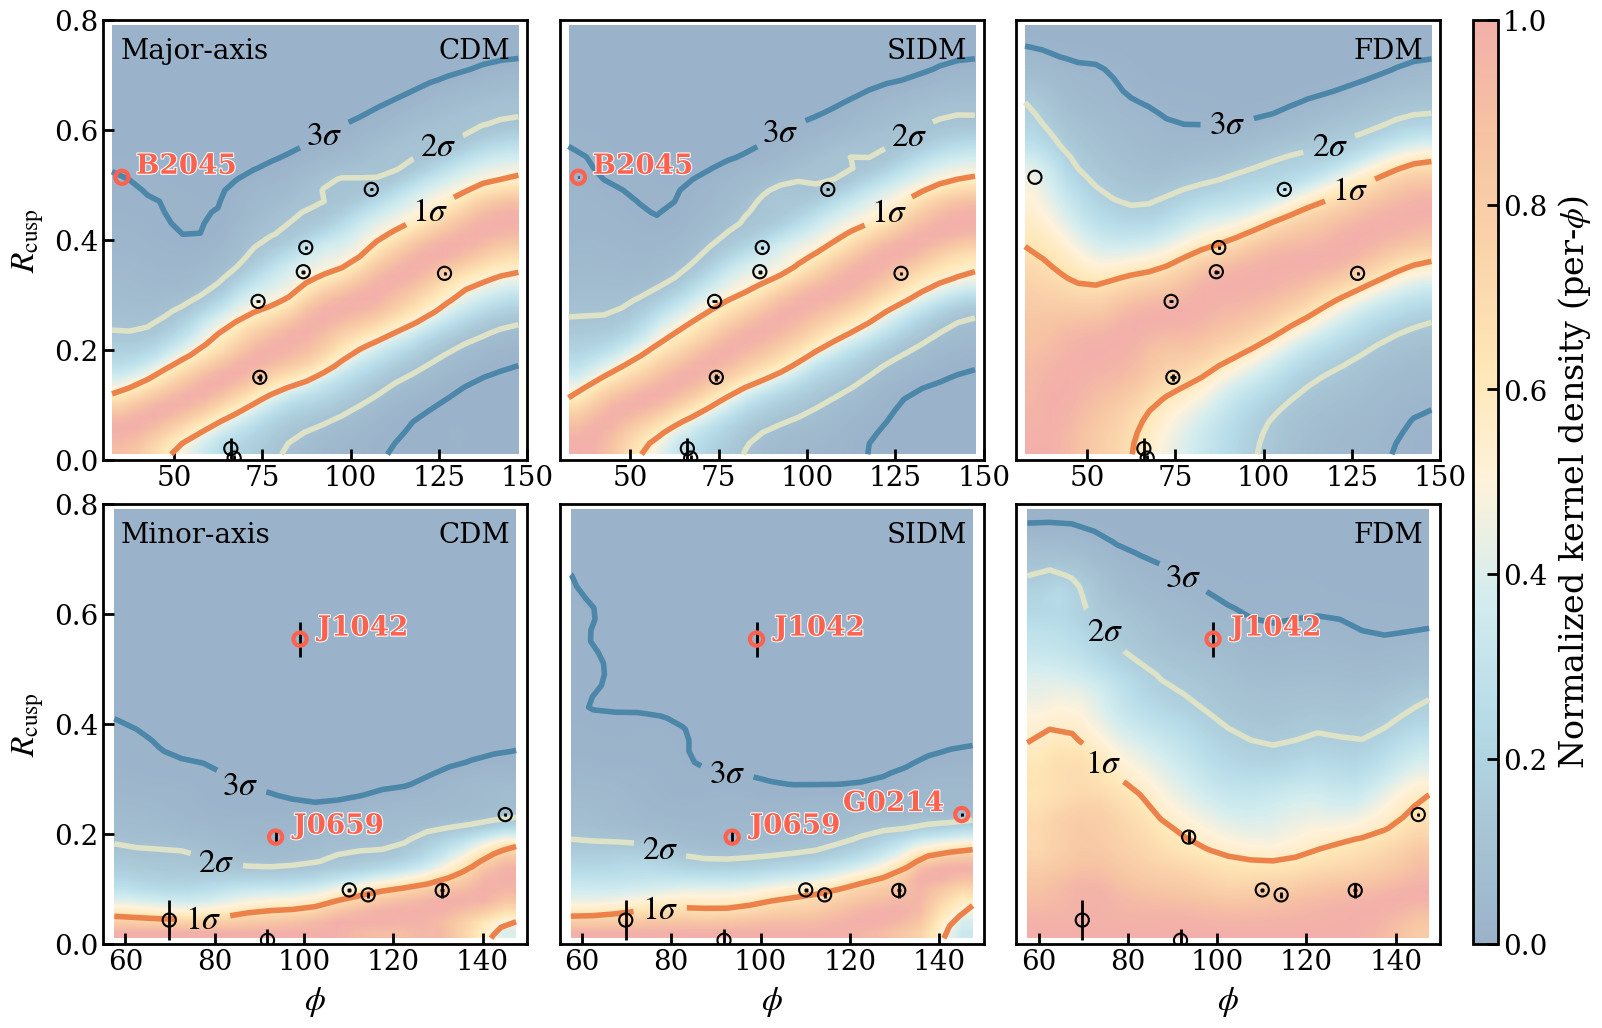

In [22]:
out_path = "KED_SIE.pdf"
sigma_label_phi ={
  "long": {
    "CDM":  {"3": 90, "2": 125, "1": 120},
    "SIDM": {"3": 90, "2": 125, "1": 120},
    "FDM":  {"3": 90, "2": 115, "1": 120},
  },
  "short": {
    "CDM":  {"3": 90, "2": 80, "1": 75},
    "SIDM": {"3": 92, "2": 80, "1": 78},
    "FDM":  {"3": 95, "2": 75, "1": 75},
}
}
plot_rcusp_phi_combined_two_axes_hpd2sigma(
    merged_by_axis_type=merged_by_axis_type,
    notion_response=response,
    output_path=out_path,
    show=True,
    notion_rcusp_max=0.8,
    cmap=cmap256.reversed(),
    grid_resolution=40,
    phi_max=150,
    phi_min_short=55,
    phi_min_long=30,
    add_colorbar=True,
    mark_outside_2sigma=True,
    bg_alpha=0.50,
    outlier_color="#FE624E",
    bin_width=5.0,
    sigma_label_phi=sigma_label_phi,
)

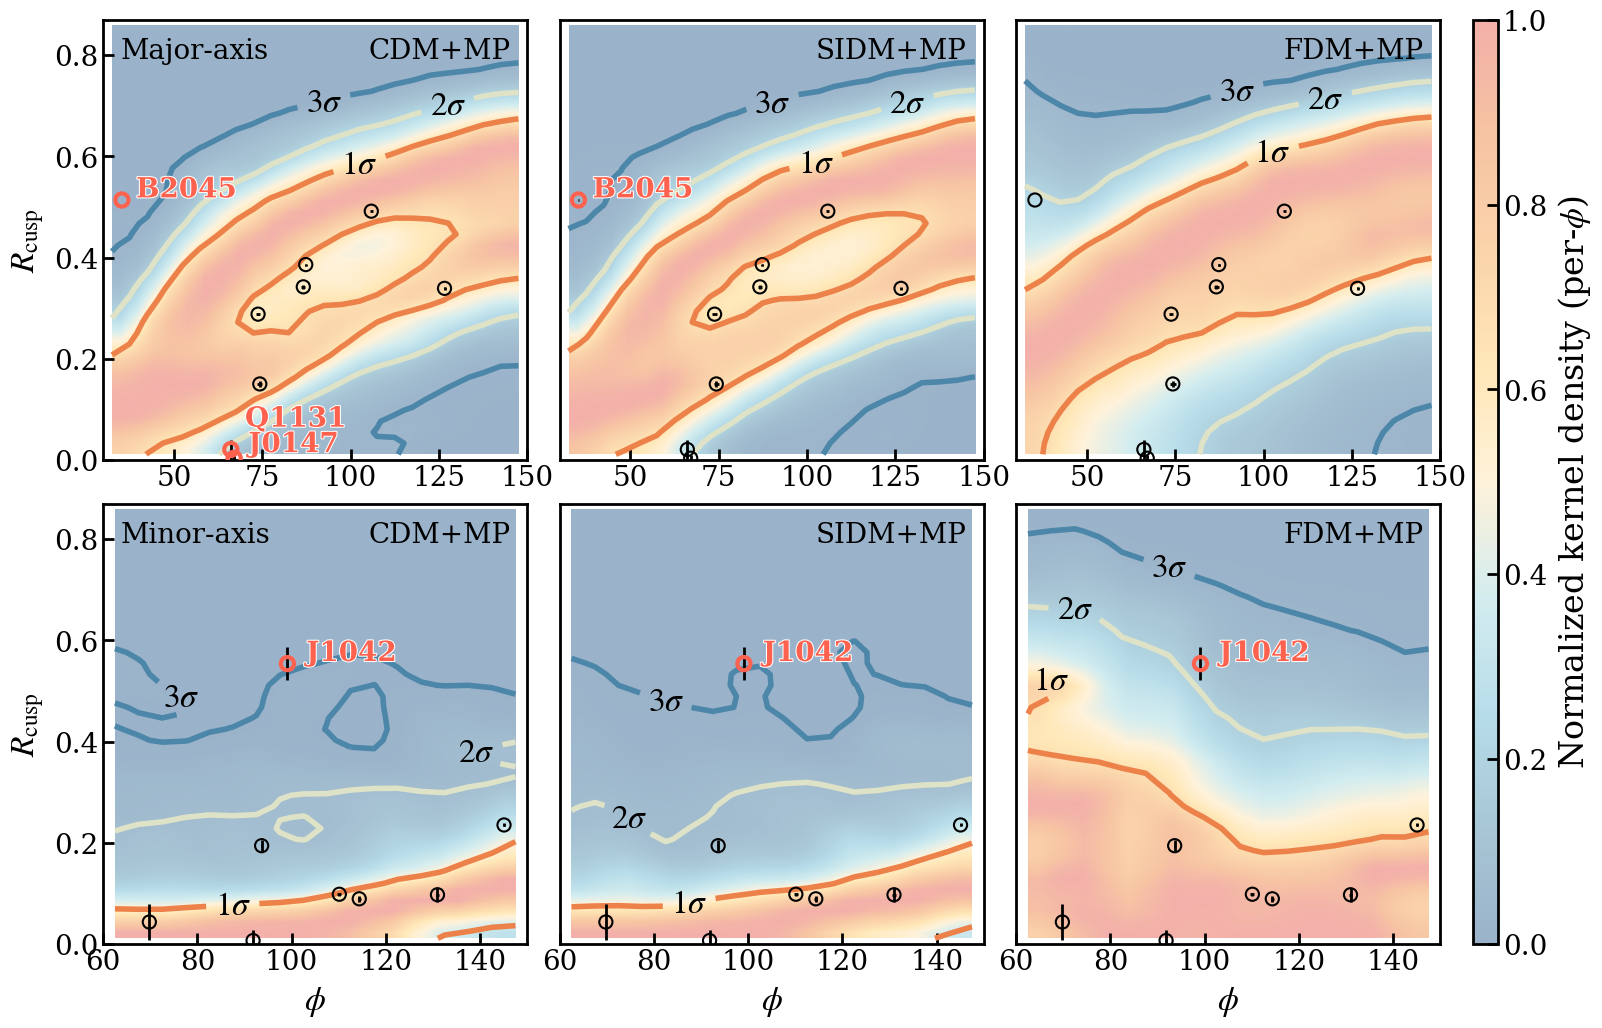

In [23]:
out_path = "KED_Multipole.pdf"
sigma_label_phi ={
  "long": {
    "CDM":  {"3": 90, "2": 125, "1": 100},
    "SIDM": {"3": 90, "2": 125, "1": 100},
    "FDM":  {"3": 90, "2": 115, "1": 100},
  },
  "short": {
    "CDM":  {"3": 90, "2": 70, "1": 85},
    "SIDM": {"3": 82, "2": 75, "1": 85},
    "FDM":  {"3": 95, "2": 75, "1": 85},
}
}
plot_rcusp_phi_combined_two_axes_hpd2sigma(
    merged_by_axis_type=merged_by_axis_type_mul,
    notion_response=response,
    output_path=out_path,
    show=True,
    notion_rcusp_max=0.87,
    cmap=cmap256.reversed(),
    grid_resolution=40,
    phi_max=150,
    phi_min_short=60,
    phi_min_long=30,
    add_colorbar=True,
    mark_outside_2sigma=True,
    bg_alpha=0.50,
    outlier_color="#FE624E",
    bin_width=5.0,
    sigma_label_phi=sigma_label_phi,
    subtex= "+MP"
)

## Supplementary plots for None case

In [24]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
def plot_rcusp_phi_none_vs_mp_2x2_hpd2sigma(
    merged_by_axis_type,
    merged_by_axis_type_mul,
    sim_type_left="None",
    sim_type_right="None",
    notion_response=None,
    output_path=None,
    show=True,
    notion_rcusp_max=0.8,
    cmap="magma",
    grid_resolution=50,
    phi_max=150,
    phi_min_short=60,
    phi_min_long=30,
    bin_width=4.0,
    smooth_sigma=1.0,
    masses=(0.683, 0.95, 0.997),
    bg_alpha=0.50,
    add_colorbar=True,
    mark_outside_2sigma=True,
    outlier_color="#FE624E",
    outlier_lw=3,
    # {
    #   "long":  {"None":{"3":90,"2":125,"1":120}, "None+MP":{"3":90,"2":115,"1":120}},
    #   "short": {"None":{"3":90,"2":80, "1":75 }, "None+MP":{"3":92,"2":80, "1":78 }},
    # }
    sigma_label_phi=None,
    sigma_fontsize=20,
    sigma_rotation=0,
    subtex=None,
):
    """
    2x2:
      Row0: long_axis  -> Major-axis
      Row1: short_axis -> Minor-axis
      Col0: None       (merged_by_axis_type)
      Col1: None+MP    (merged_by_axis_type_mul)
    Notion points: black hollow circles with error bars; >2σ (95%) get an outlier ring and matching label.
    2σ threshold based on HPD-like levels from norm_density_grid (P-grid).
    """
    import matplotlib.patheffects as pe
    col_names = ["None", "None+MP"]
    Rcusp_min, Rcusp_max = 0.0, notion_rcusp_max
    # ============================================================
    # ============================================================
    def _build_edges(phi_min_local):
        phi_edges = np.arange(phi_min_local, phi_max + bin_width, bin_width)
        rcusp_edges = np.linspace(Rcusp_min, Rcusp_max, grid_resolution + 1)
        return phi_edges, rcusp_edges
    def _collect_model_points(sim_dict, sim_type):
        R = np.asarray(sim_dict.get(sim_type, {}).get("Rcusp", np.array([]))).ravel()
        P = np.asarray(sim_dict.get(sim_type, {}).get("phi",   np.array([]))).ravel()
        W = np.asarray(sim_dict.get(sim_type, {}).get("w",     np.array([]))).ravel()
        if R.size == 0 or P.size == 0:
            return None, None, None
        n = min(R.size, P.size)
        R = R[:n]
        P = P[:n]
        if W.size != n:
            W = np.ones_like(R, dtype=float)
        else:
            W = W[:n].astype(float)
        return P, R, W
    def _compute_norm_density_grid(phi, rcusp, w, phi_edges, rcusp_edges):
        w_pos = np.clip(w, 0.0, None)
        if not np.any(w_pos > 0):
            w_pos = np.ones_like(w_pos)
        H, _, _ = np.histogram2d(phi, rcusp, bins=[phi_edges, rcusp_edges], weights=w_pos)
        H = gaussian_filter(H, sigma=smooth_sigma)
        H = np.clip(H, 0.0, None)
        if H.sum() <= 0:
            return None
        norm = np.zeros_like(H)
        for j in range(H.shape[0]):  # phi bins
            col = H[j]
            mask = col > 0
            if np.any(mask):
                cmin = col[mask].min()
                cmax = col[mask].max()
                if cmax > cmin:
                    norm[j] = (col - cmin) / (cmax - cmin)
        return norm
    def _hpd_levels_from_Z(Z, masses=(0.683, 0.95, 0.997)):
        Z = np.asarray(Z, dtype=float)
        Z = np.clip(Z, 0.0, None)
        tot = Z.sum()
        if tot <= 0:
            return None, None
        P = Z / tot
        flat = P.ravel()
        order = np.argsort(flat)[::-1]
        cdf = np.cumsum(flat[order])
        levels = []
        for m in masses:
            idx = np.searchsorted(cdf, m)
            levels.append(flat[order[min(idx, flat.size - 1)]])
        return sorted(levels), P  # ascending: [3σ,2σ,1σ]
    def _bin_index(phi, rc, phi_edges, rc_edges, P_grid):
        bphi = np.searchsorted(phi_edges, phi, side="right") - 1
        br   = np.searchsorted(rc_edges,  rc,  side="right") - 1
        if bphi < 0 or br < 0:
            return None
        if bphi >= P_grid.shape[0] or br >= P_grid.shape[1]:
            return None
        return bphi, br
    def _to_float_safe(x):
        try:
            if x is None:
                return None
            return float(str(x).replace("±", "").strip())
        except (TypeError, ValueError):
            return None
    # ============================================================
    # [Block 2] Notion overlay
    # ============================================================
    def _overlay_notion_points_and_mark_2sigma(
        ax, axis_filter, phi_edges, rc_edges, P_grid, levels_sorted, phi_min_local
    ):
        if notion_response is None:
            return
        from notion import get_lens_data_by_name, get_all_lens_names
        th_2sigma = None
        if (levels_sorted is not None) and (len(levels_sorted) >= 2):
            th_2sigma = levels_sorted[1]
        placed_texts = []
        def _clamp_text_pos(x, y, phi_min_local, phi_max_local, pad_x=5.0, pad_y=0.03):
            x = min(max(x, phi_min_local + pad_x), phi_max_local - pad_x)
            y = min(max(y, Rcusp_min + pad_y), Rcusp_max - pad_y)
            return x, y
        def _repel_text_pos(x, y, placed, repel_dx=10.0, repel_dy=0.04, step_y=0.04, max_tries=18):
            for _ in range(max_tries):
                ok = True
                for (px, py) in placed:
                    if abs(x - px) < repel_dx and abs(y - py) < repel_dy:
                        ok = False
                        break
                if ok:
                    break
                y += step_y
            return x, y
        names = get_all_lens_names(notion_response) or []
        for name in names:
            d = get_lens_data_by_name(notion_response, name)
            if not isinstance(d, dict):
                continue
            phi         = _to_float_safe(d.get("phi"))
            rcusp       = _to_float_safe(d.get("Rcusp"))
            phi_sigma   = _to_float_safe(d.get("phi_sigma"))
            rcusp_sigma = _to_float_safe(d.get("Rcusp_sigma"))
            axis_type   = (d.get("axis_type") or "").strip().lower()
            if phi is None or rcusp is None:
                continue
            if not (math.isfinite(phi) and math.isfinite(rcusp)):
                continue
            if rcusp > notion_rcusp_max:
                continue
            if axis_type not in ("long", "short"):
                continue
            if axis_filter is not None and axis_type != axis_filter:
                continue
            has_xerr = (phi_sigma is not None) and math.isfinite(phi_sigma) and (phi_sigma > 0)
            has_yerr = (rcusp_sigma is not None) and math.isfinite(rcusp_sigma) and (rcusp_sigma > 0)
            if has_xerr or has_yerr:
                ax.errorbar(
                    phi, rcusp,
                    xerr=phi_sigma if has_xerr else None,
                    yerr=rcusp_sigma if has_yerr else None,
                    fmt="none",
                    ecolor="black",
                    elinewidth=2.0,
                    capsize=0,
                    alpha=1,
                    zorder=10
                )
            # black hollow
            ax.scatter(
                [phi], [rcusp],
                facecolors="none",
                edgecolors="black",
                marker="o",
                s=90,
                linewidths=1.5,
                alpha=1,
                zorder=11
            )
            # outside 2σ?
            if (mark_outside_2sigma and (P_grid is not None) and (th_2sigma is not None) and math.isfinite(th_2sigma)):
                idx = _bin_index(phi, rcusp, phi_edges, rc_edges, P_grid)
                if idx is None:
                    continue
                bphi, br = idx
                pval = float(P_grid[bphi, br])
                if pval < th_2sigma:
                    ax.scatter(
                        [phi], [rcusp],
                        facecolors="none",
                        edgecolors=outlier_color,
                        marker="o",
                        s=90,
                        linewidths=outlier_lw,
                        alpha=1.0,
                        zorder=20
                    )
                    nm = str(name).strip()
                    x_text = phi + 4.0
                    y_text = rcusp + 0.02
                    ha = "left"
                    if x_text > (phi_max - 6.0):
                        x_text = phi - 4.0
                        ha = "right"
                    x_text, y_text = _clamp_text_pos(x_text, y_text, phi_min_local, phi_max)
                    x_text, y_text = _repel_text_pos(x_text, y_text, placed_texts)
                    t = ax.text(
                        x_text, y_text, nm,
                        color=outlier_color,
                        fontsize=20,
                        ha=ha,
                        fontweight="bold",
                        va="center",
                        zorder=13,
                        clip_on=True
                    )
                    t.set_path_effects([pe.withStroke(linewidth=1.5, foreground="white")])
                    placed_texts.append((x_text, y_text))
    # ============================================================
    # ============================================================
    def _get_phi_target(axis_filter, col_name, which_sigma, phi_min_local):
        default_phi = 0.5 * (phi_min_local + phi_max)
        if not isinstance(sigma_label_phi, dict):
            return default_phi
        row = sigma_label_phi.get(axis_filter, {})
        panel = row.get(col_name, {})
        val = panel.get(which_sigma, None)
        try:
            return float(val) if val is not None else default_phi
        except Exception:
            return default_phi
    def _find_point_near_phi_on_level(cs, phi_target, prefer="top", x_window=2.0):
        if cs is None or (not hasattr(cs, "levels")) or len(cs.levels) == 0:
            return None
        if not hasattr(cs, "allsegs") or len(cs.allsegs) == 0:
            return None
        segs = cs.allsegs[0]
        if segs is None or len(segs) == 0:
            return None
        best = None
        best_y = None
        for seg in segs:
            if seg is None or seg.shape[0] < 2:
                continue
            dx = np.abs(seg[:, 0] - phi_target)
            min_dx = float(dx.min())
            mask = dx <= (min_dx + float(x_window))
            cand = seg[mask]
            if cand.shape[0] == 0:
                continue
            if prefer == "bottom":
                k = int(np.argmin(cand[:, 1]))
            else:
                k = int(np.argmax(cand[:, 1]))
            xy = (float(cand[k, 0]), float(cand[k, 1]))
            if best is None:
                best, best_y = xy, xy[1]
            else:
                if prefer == "bottom":
                    if xy[1] < best_y:
                        best, best_y = xy, xy[1]
                else:
                    if xy[1] > best_y:
                        best, best_y = xy, xy[1]
        return best
    def _place_sigma_label_on_single_cs(ax, cs_single, label_text, phi_target, color, fontsize):
        if cs_single is None or (not hasattr(cs_single, "levels")) or len(cs_single.levels) == 0:
            return
        level_exact = float(cs_single.levels[0])
        best_xy = _find_point_near_phi_on_level(cs_single, phi_target, prefer="top", x_window=2.0)
        if best_xy is None:
            return
        try:
            texts = ax.clabel(
                cs_single,
                levels=[level_exact],
                inline=True,
                inline_spacing=10,
                manual=[best_xy],
                fmt={level_exact: label_text},
                fontsize=fontsize,
                # colors=[color],
                colors = 'k',
                zorder=6
            )
            for t in texts:
                t.set_fontweight("bold")
                t.set_rotation(sigma_rotation)
                # t.set_path_effects([pe.withStroke(linewidth=1.5, foreground="white")])
        except Exception:
            t = ax.text(
                best_xy[0], best_xy[1],
                label_text,
                color=color,
                fontsize=fontsize,
                fontweight="bold",
                ha="center", va="center",
                rotation=sigma_rotation,
                zorder=6,
                clip_on=True
            )
            t.set_path_effects([pe.withStroke(linewidth=1.5, foreground="white")])
    # ============================================================
    # [Block 4] Figure layout (2x2 + colorbar)
    # ============================================================
    fig = plt.figure(figsize=(12, 10), facecolor="white")
    gs = fig.add_gridspec(2, 3, width_ratios=[1.0, 1.0, 0.06], wspace=0.10, hspace=0.10)
    axes = np.empty((2, 2), dtype=object)
    for rr in range(2):
        for cc in range(2):
            axes[rr, cc] = fig.add_subplot(gs[rr, cc])
    cax = fig.add_subplot(gs[:, 2]) if add_colorbar else None
    base_cmap = plt.get_cmap(cmap) if isinstance(cmap, str) else cmap
    sm = plt.cm.ScalarMappable(cmap=base_cmap, norm=plt.Normalize(vmin=0.0, vmax=1.0))
    sm.set_array([])
    row_keys = [
        ("long_axis",  "long",  phi_min_long,  "Major-axis"),
        ("short_axis", "short", phi_min_short, "Minor-axis"),
    ]
    col_sources = [
        (merged_by_axis_type,     sim_type_left,  "Smooth"),
        (merged_by_axis_type_mul, sim_type_right, "Smooth+MP"),
    ]
    # ============================================================
    # [Block 5] Main loop
    # ============================================================
    for r, (axis_key, axis_filter, phi_min_local, axis_tag) in enumerate(row_keys):
        for c, (merged_src, sim_type_key, col_name) in enumerate(col_sources):
            ax = axes[r, c]
            ax.set_facecolor("white")
            sim_dict = merged_src.get(axis_key, {})
            phi, rcusp, w = _collect_model_points(sim_dict, sim_type_key)
            if phi is None:
                ax.set_axis_off()
                continue
            phi_edges, rc_edges = _build_edges(phi_min_local)
            norm_grid = _compute_norm_density_grid(phi, rcusp, w, phi_edges, rc_edges)
            if norm_grid is None:
                ax.set_axis_off()
                continue
            # background
            phi_c = 0.5 * (phi_edges[:-1] + phi_edges[1:])
            rc_c  = 0.5 * (rc_edges[:-1] + rc_edges[1:])
            X, Y = np.meshgrid(phi_c, rc_c, indexing="xy")
            ax.imshow(
                norm_grid.T,
                origin="lower",
                extent=[phi_c.min(), phi_c.max(), rc_c.min(), rc_c.max()],
                cmap=base_cmap,
                alpha=bg_alpha,
                aspect="auto",
                zorder=1,
                interpolation="bilinear"
            )
            # HPD levels
            levels_sorted, P_grid = _hpd_levels_from_Z(norm_grid, masses=masses)
            # Notion overlay
            _overlay_notion_points_and_mark_2sigma(
                ax=ax,
                axis_filter=axis_filter,
                phi_edges=phi_edges,
                rc_edges=rc_edges,
                P_grid=P_grid,
                levels_sorted=levels_sorted,
                phi_min_local=phi_min_local
            )
            # panel labels
            title = col_name if subtex is None else f"{col_name}{subtex}"
            ax.text(0.96, 0.96, title, transform=ax.transAxes, ha="right", va="top", color="black", zorder=20)
            if c == 0:
                ax.text(0.04, 0.96, axis_tag, transform=ax.transAxes, ha="left", va="top", color="black", zorder=30)
            # contours + sigma labels
            if (levels_sorted is not None) and (P_grid is not None) and (len(levels_sorted) >= 3):
                Z_sig = P_grid.T
                cm = plt.get_cmap(cmap) if isinstance(cmap, str) else cmap
                line_colors = [cm(0.1), cm(0.45), cm(0.9)]  # 3σ,2σ,1σ
                phi3 = _get_phi_target(axis_filter, col_name, "3", phi_min_local)
                phi2 = _get_phi_target(axis_filter, col_name, "2", phi_min_local)
                phi1 = _get_phi_target(axis_filter, col_name, "1", phi_min_local)
                items = [
                    (levels_sorted[0], r"$3\sigma$", phi3, line_colors[0]),
                    (levels_sorted[1], r"$2\sigma$", phi2, line_colors[1]),
                    (levels_sorted[2], r"$1\sigma$", phi1, line_colors[2]),
                ]
                for lev, lab, phit, col in items:
                    cs_i = ax.contour(
                        X, Y, Z_sig,
                        levels=[lev],
                        colors=[col],
                        linewidths=[4.0],
                        linestyles="solid",
                        zorder=4
                    )
                    _place_sigma_label_on_single_cs(ax, cs_i, lab, phit, col, sigma_fontsize)
            # limits
            ax.set_xlim(phi_min_local, phi_max)
            ax.set_ylim(Rcusp_min, Rcusp_max)
            # labels
            if c == 0:
                ax.set_ylabel(r"$R_{\rm cusp}$")
            else:
                ax.set_ylabel("")
                ax.set_yticks([])
            if r == 1:
                ax.set_xlabel(r"$\phi$")
            else:
                ax.set_xlabel("")
    # ============================================================
    # [Block 6] Colorbar + save/show
    # ============================================================
    if add_colorbar and (cax is not None):
        cbar = fig.colorbar(sm, cax=cax)
        cbar.set_label("Normalized kernel density (per-$\\phi$)")
        # &&&!!!(2026-01-08)
        for spine in cbar.ax.spines.values():
            spine.set_alpha(1.0)
        cbar.solids.set_alpha(0.5)
    if output_path:
        outdir = os.path.dirname(output_path)
        if outdir:
            os.makedirs(outdir, exist_ok=True)
        plt.savefig(output_path, dpi=300, facecolor="white", bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close()

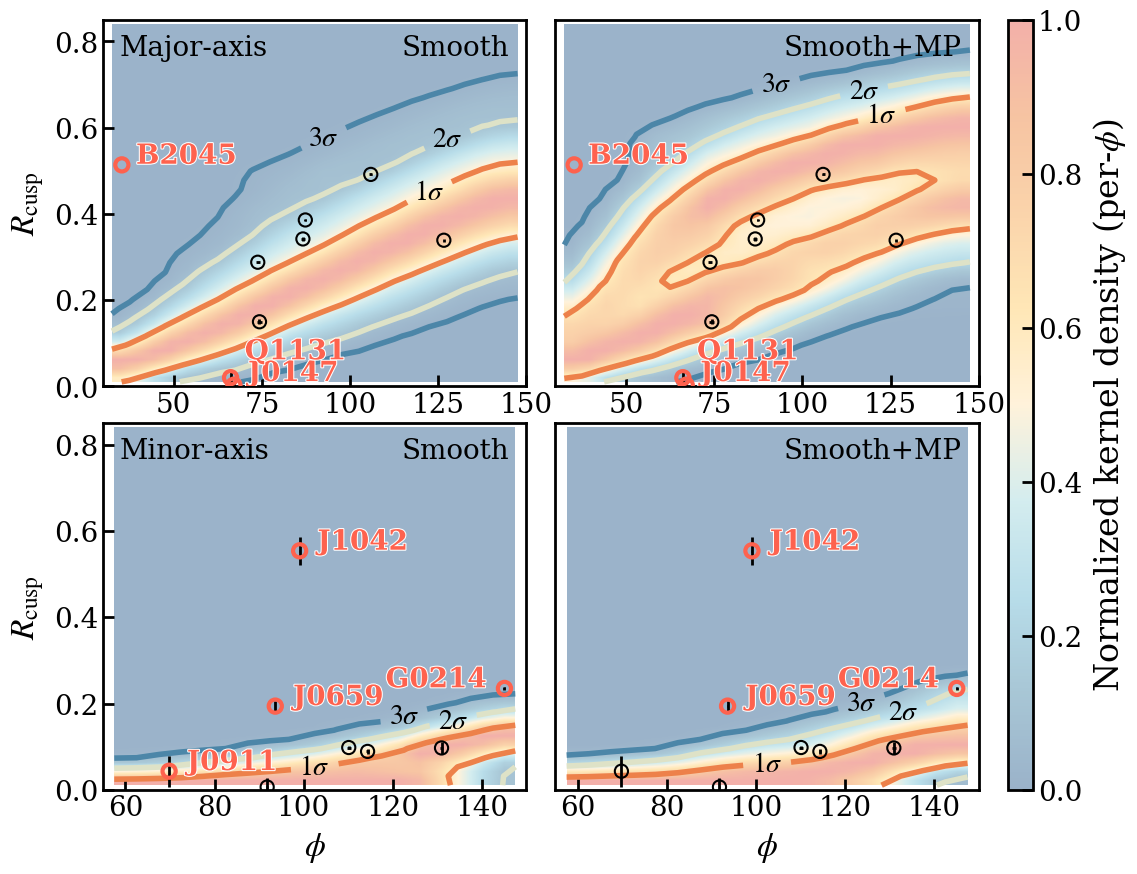

In [25]:
out_path = "KDE_None_vs_NoneMP_2x2.pdf"
sigma_label_phi = {
  "long": {
    "Smooth":    {"3": 90, "2": 125, "1": 120},
    "Smooth+MP": {"3": 90, "2": 115, "1": 120},
  },
  "short": {
    "Smooth":    {"3": 120, "2": 130,  "1": 100},
    "Smooth+MP": {"3": 120, "2": 130,  "1": 100},
  }
}
plot_rcusp_phi_none_vs_mp_2x2_hpd2sigma(
    merged_by_axis_type=merged_by_axis_type,
    merged_by_axis_type_mul=merged_by_axis_type_mul,
    sim_type_left="None",
    sim_type_right="None",
    notion_response=response,
    output_path=out_path,
    show=True,
    notion_rcusp_max=0.85,
    cmap=cmap256.reversed(),
    grid_resolution=40,
    phi_max=150,
    phi_min_short=55,
    phi_min_long=30,
    add_colorbar=True,
    mark_outside_2sigma=True,
    bg_alpha=0.50,
    outlier_color="#FE624E",
    bin_width=5.0,
    sigma_label_phi=sigma_label_phi,
)

In [7]:
import math
import numpy as np
from scipy.ndimage import gaussian_filter
def classify_notion_points_by_sigma_2x2(
    merged_by_axis_type,
    merged_by_axis_type_mul,
    sim_type_left="None",
    sim_type_right="None",
    notion_response=None,
    notion_rcusp_max=0.85,
    grid_resolution=40,
    phi_max=150,
    phi_min_short=55,
    phi_min_long=30,
    bin_width=5.0,
    smooth_sigma=1.0,
    masses=(0.683, 0.95, 0.997),
):
    """
    Outputs sigma-bin results per panel for Notion points:
      - in_1sigma
      - in_1_2sigma
      - in_2_3sigma
      - out_3sigma
    There are four panels:
      Smooth Major, Smooth+MP Major, Smooth Minor, Smooth+MP Minor
    Returns:
      result[panel_name][bin_name] = list of dicts
    Each dict has: name, phi, rcusp, pval
    """
    if notion_response is None:
        raise ValueError("notion_response cannot be empty (required to extract Notion points).")
    Rcusp_min, Rcusp_max = 0.0, float(notion_rcusp_max)
    def _build_edges(phi_min_local):
        phi_edges = np.arange(phi_min_local, phi_max + bin_width, bin_width)
        rcusp_edges = np.linspace(Rcusp_min, Rcusp_max, grid_resolution + 1)
        return phi_edges, rcusp_edges
    def _collect_model_points(sim_dict, sim_type):
        R = np.asarray(sim_dict.get(sim_type, {}).get("Rcusp", np.array([]))).ravel()
        P = np.asarray(sim_dict.get(sim_type, {}).get("phi",   np.array([]))).ravel()
        W = np.asarray(sim_dict.get(sim_type, {}).get("w",     np.array([]))).ravel()
        if R.size == 0 or P.size == 0:
            return None, None, None
        n = min(R.size, P.size)
        R, P = R[:n], P[:n]
        if W.size != n:
            W = np.ones_like(R, dtype=float)
        else:
            W = W[:n].astype(float)
        return P, R, W
    def _compute_norm_density_grid(phi, rcusp, w, phi_edges, rcusp_edges):
        w_pos = np.clip(w, 0.0, None)
        if not np.any(w_pos > 0):
            w_pos = np.ones_like(w_pos)
        H, _, _ = np.histogram2d(phi, rcusp, bins=[phi_edges, rcusp_edges], weights=w_pos)
        H = gaussian_filter(H, sigma=smooth_sigma)
        H = np.clip(H, 0.0, None)
        if H.sum() <= 0:
            return None
        norm = np.zeros_like(H)
        for j in range(H.shape[0]):
            col = H[j]
            mask = col > 0
            if np.any(mask):
                cmin = col[mask].min()
                cmax = col[mask].max()
                if cmax > cmin:
                    norm[j] = (col - cmin) / (cmax - cmin)
        return norm
    def _hpd_levels_from_Z(Z, masses=(0.683, 0.95, 0.997)):
        Z = np.asarray(Z, dtype=float)
        Z = np.clip(Z, 0.0, None)
        tot = Z.sum()
        if tot <= 0:
            return None, None
        P = Z / tot
        flat = P.ravel()
        order = np.argsort(flat)[::-1]
        cdf = np.cumsum(flat[order])
        levels = []
        for m in masses:
            idx = np.searchsorted(cdf, m)
            levels.append(flat[order[min(idx, flat.size - 1)]])
        return sorted(levels), P
    def _bin_index(phi, rc, phi_edges, rc_edges, P_grid):
        bphi = np.searchsorted(phi_edges, phi, side="right") - 1
        br = np.searchsorted(rc_edges, rc, side="right") - 1
        if bphi < 0 or br < 0:
            return None
        if bphi >= P_grid.shape[0] or br >= P_grid.shape[1]:
            return None
        return bphi, br
    def _to_float_safe(x):
        try:
            if x is None:
                return None
            return float(str(x).replace("±", "").strip())
        except (TypeError, ValueError):
            return None
    from notion import get_lens_data_by_name, get_all_lens_names
    notion_points = []
    names = get_all_lens_names(notion_response) or []
    for name in names:
        d = get_lens_data_by_name(notion_response, name)
        if not isinstance(d, dict):
            continue
        phi = _to_float_safe(d.get("phi"))
        rcusp = _to_float_safe(d.get("Rcusp"))
        axis_type = (d.get("axis_type") or "").strip().lower()
        if phi is None or rcusp is None:
            continue
        if not (math.isfinite(phi) and math.isfinite(rcusp)):
            continue
        if rcusp > notion_rcusp_max:
            continue
        if axis_type not in ("long", "short"):
            continue
        notion_points.append(
            {"name": str(name).strip(), "phi": float(phi), "rcusp": float(rcusp), "axis_type": axis_type}
        )
    panels = [
        # panel_key, axis_key, axis_filter, phi_min_local, merged_src, sim_type_key
        ("Smooth Major",     "long_axis",  "long",  phi_min_long,  merged_by_axis_type,     sim_type_left),
        ("Smooth+MP Major",  "long_axis",  "long",  phi_min_long,  merged_by_axis_type_mul, sim_type_right),
        ("Smooth Minor",     "short_axis", "short", phi_min_short, merged_by_axis_type,     sim_type_left),
        ("Smooth+MP Minor",  "short_axis", "short", phi_min_short, merged_by_axis_type_mul, sim_type_right),
    ]
    result = {}
    for panel_name, axis_key, axis_filter, phi_min_local, merged_src, sim_type_key in panels:
        result[panel_name] = {
            "in_1sigma": [],
            "in_1_2sigma": [],
            "in_2_3sigma": [],
            "out_3sigma": [],
        }
        sim_dict = merged_src.get(axis_key, {})
        phi_m, rc_m, w_m = _collect_model_points(sim_dict, sim_type_key)
        if phi_m is None:
            continue
        phi_edges, rc_edges = _build_edges(phi_min_local)
        norm_grid = _compute_norm_density_grid(phi_m, rc_m, w_m, phi_edges, rc_edges)
        if norm_grid is None:
            continue
        levels_sorted, P_grid = _hpd_levels_from_Z(norm_grid, masses=masses)
        if (levels_sorted is None) or (P_grid is None) or (len(levels_sorted) < 3):
            continue
        th3, th2, th1 = levels_sorted[0], levels_sorted[1], levels_sorted[2]
        for pt in notion_points:
            if pt["axis_type"] != axis_filter:
                continue
            idx = _bin_index(pt["phi"], pt["rcusp"], phi_edges, rc_edges, P_grid)
            if idx is None:
                continue
            bphi, br = idx
            pval = float(P_grid[bphi, br])
            item = {"name": pt["name"], "phi": pt["phi"], "rcusp": pt["rcusp"], "pval": pval}
            if pval >= th1:
                result[panel_name]["in_1sigma"].append(item)
            elif (pval >= th2) and (pval < th1):
                result[panel_name]["in_1_2sigma"].append(item)
            elif (pval >= th3) and (pval < th2):
                result[panel_name]["in_2_3sigma"].append(item)
            else:
                result[panel_name]["out_3sigma"].append(item)
        for k in result[panel_name]:
            result[panel_name][k].sort(key=lambda x: x["pval"], reverse=True)
    return result
def pretty_print_sigma_bins(result_dict, digits=4):
    """ classify . """
    for panel, bins in result_dict.items():
        print(f"\n==== {panel} ====")
        for bn in ["in_1sigma", "in_1_2sigma", "in_2_3sigma", "out_3sigma"]:
            arr = bins.get(bn, [])
            print(f"  {bn}: {len(arr)}")
            for it in arr:
                print(
                    f"    - {it['name']}: phi={it['phi']:.2f}, Rcusp={it['rcusp']:.3f}, p={it['pval']:.{digits}g}"
                )

In [8]:
res = classify_notion_points_by_sigma_2x2(
    merged_by_axis_type=merged_by_axis_type,
    merged_by_axis_type_mul=merged_by_axis_type_mul,
    sim_type_left="None",
    sim_type_right="None",
    notion_response=response,
    notion_rcusp_max=0.85,
    grid_resolution=40,
    phi_max=150,
    phi_min_short=55,
    phi_min_long=30,
    bin_width=5.0,
    smooth_sigma=1.0,
)
pretty_print_sigma_bins(res)


==== Smooth Major ====
  in_1sigma: 2
    - B1422: phi=74.32, Rcusp=0.150, p=0.005109
    - J1433: phi=126.75, Rcusp=0.339, p=0.00406
  in_1_2sigma: 4
    - J0833: phi=86.63, Rcusp=0.318, p=0.002638
    - J0429: phi=96.34, Rcusp=0.386, p=0.001848
    - J0630: phi=67.35, Rcusp=0.288, p=0.001196
    - B1608: phi=105.87, Rcusp=0.492, p=0.000572
  in_2_3sigma: 2
    - J0147: phi=67.07, Rcusp=0.003, p=0.0001014
    - Q1131: phi=66.12, Rcusp=0.020, p=0.0001014
  out_3sigma: 1
    - B2045: phi=35.30, Rcusp=0.514, p=2.551e-09

==== Smooth+MP Major ====
  in_1sigma: 3
    - B1422: phi=74.32, Rcusp=0.150, p=0.002701
    - B1608: phi=105.87, Rcusp=0.492, p=0.002502
    - J1433: phi=126.75, Rcusp=0.339, p=0.001791
  in_1_2sigma: 3
    - J0630: phi=67.35, Rcusp=0.288, p=0.001786
    - J0833: phi=86.63, Rcusp=0.318, p=0.001701
    - J0429: phi=96.34, Rcusp=0.386, p=0.001403
  in_2_3sigma: 0
  out_3sigma: 3
    - J0147: phi=67.07, Rcusp=0.003, p=4.424e-05
    - Q1131: phi=66.12, Rcusp=0.020, p=4.424

# Output density for each point

In [26]:
import math
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter
def print_notion_points_norm_and_sigma_band_by_axis_sorted(
    merged_by_axis_type,
    notion_response,
    notion_rcusp_max=0.8,
    grid_resolution=40,
    phi_max=150.0,
    phi_min_short=55.0,
    phi_min_long=30.0,
    bin_width=5.0,
    smooth_sigma=1.0,
    masses=(0.683, 0.95, 0.997),  # 1σ/2σ/3σ HPD mass
    sim_type_list=("None","CDM", "SIDM", "FDM"),
):
    """
    Group by axis_type (long/short) and print in ascending phi within each group.
    Output columns (one set per model):
      - norm_{MODEL}
      - band_{MODEL}  ∈ {"in 1σ", "1–2σ", "2–3σ", "out 3σ"}
    Notes:
    - band_{MODEL}  HPD-like ( P_grid). 
    """
    from notion import get_lens_data_by_name, get_all_lens_names
    Rcusp_min, Rcusp_max = 0.0, float(notion_rcusp_max)
    # ---------------- utils ----------------
    def _to_float_safe(x):
        try:
            if x is None:
                return None
            return float(str(x).replace("±", "").strip())
        except (TypeError, ValueError):
            return None
    def _build_edges(phi_min_local):
        phi_edges = np.arange(phi_min_local, phi_max + bin_width, bin_width)
        rc_edges = np.linspace(Rcusp_min, Rcusp_max, grid_resolution + 1)
        return phi_edges, rc_edges
    def _collect_model_points(sim_dict, sim_type):
        R = np.asarray(sim_dict.get(sim_type, {}).get("Rcusp", np.array([]))).ravel()
        P = np.asarray(sim_dict.get(sim_type, {}).get("phi",   np.array([]))).ravel()
        W = np.asarray(sim_dict.get(sim_type, {}).get("w",     np.array([]))).ravel()
        if R.size == 0 or P.size == 0:
            return None, None, None
        n = min(R.size, P.size)
        R, P = R[:n], P[:n]
        W = np.ones_like(R) if W.size != n else W[:n].astype(float)
        return P, R, W
    def _compute_norm_density_grid(phi, rcusp, w, phi_edges, rc_edges):
        w = np.clip(w, 0.0, None)
        if not np.any(w > 0):
            w = np.ones_like(w)
        H, _, _ = np.histogram2d(phi, rcusp, bins=[phi_edges, rc_edges], weights=w)
        H = gaussian_filter(H, sigma=smooth_sigma)
        H = np.clip(H, 0.0, None)
        if H.sum() <= 0:
            return None
        norm = np.zeros_like(H)
        for j in range(H.shape[0]):  # per-φ bin
            col = H[j]
            mask = col > 0
            if np.any(mask):
                cmin, cmax = col[mask].min(), col[mask].max()
                if cmax > cmin:
                    norm[j] = (col - cmin) / (cmax - cmin)
        return norm
    def _hpd_levels_from_Z(Z, masses=(0.683, 0.95, 0.997)):
        """
        Input Z (norm_grid), normalize to P_grid, then compute HPD thresholds (ascending: [3σ,2σ,1σ])
        """
        Z = np.asarray(Z, dtype=float)
        Z = np.clip(Z, 0.0, None)
        tot = Z.sum()
        if tot <= 0:
            return None, None
        P = Z / tot
        flat = P.ravel()
        order = np.argsort(flat)[::-1]
        cdf = np.cumsum(flat[order])
        levels = []
        for m in masses:
            idx = np.searchsorted(cdf, m)
            levels.append(flat[order[min(idx, flat.size - 1)]])
        return sorted(levels), P  # ascending: [3σ, 2σ, 1σ]
    def _bin_index(phi, rc, phi_edges, rc_edges, grid):
        bphi = np.searchsorted(phi_edges, phi, side="right") - 1
        br = np.searchsorted(rc_edges, rc, side="right") - 1
        if bphi < 0 or br < 0:
            return None
        if bphi >= grid.shape[0] or br >= grid.shape[1]:
            return None
        return bphi, br
    def _sigma_band(pval, levels_sorted):
        """
        levels_sorted ascending: [th_3sigma, th_2sigma, th_1sigma]
        """
        if levels_sorted is None or len(levels_sorted) < 3 or (pval is None) or (not math.isfinite(pval)):
            return "NA"
        th3, th2, th1 = levels_sorted[0], levels_sorted[1], levels_sorted[2]
        if pval >= th1:
            return "in 1σ"
        if pval >= th2:
            return "1–2σ"
        if pval >= th3:
            return "2–3σ"
        return "out 3σ"
    # --------- 1) cache per-panel: norm_grid + P_grid + levels ----------
    panel_info = {}
    for axis_key, axis_filter, phi_min_local in [
        ("long_axis", "long",  float(phi_min_long)),
        ("short_axis", "short", float(phi_min_short)),
    ]:
        sim_dict = merged_by_axis_type.get(axis_key, {})
        phi_edges, rc_edges = _build_edges(phi_min_local)
        for sim_type in sim_type_list:
            phi, rcusp, w = _collect_model_points(sim_dict, sim_type)
            norm = None
            P_grid = None
            levels_sorted = None
            if phi is not None:
                norm = _compute_norm_density_grid(phi, rcusp, w, phi_edges, rc_edges)
                if norm is not None:
                    levels_sorted, P_grid = _hpd_levels_from_Z(norm, masses=masses)
            panel_info[(axis_filter, sim_type)] = {
                "phi_edges": phi_edges,
                "rc_edges": rc_edges,
                "norm": norm,                # for norm_{MODEL}
                "P_grid": P_grid,            # for band_{MODEL}
                "levels_sorted": levels_sorted,
            }
    # --------- 2) extract notion points ----------
    rows = []
    for name in get_all_lens_names(notion_response) or []:
        d = get_lens_data_by_name(notion_response, name)
        if not isinstance(d, dict):
            continue
        phi = _to_float_safe(d.get("phi"))
        rcusp = _to_float_safe(d.get("Rcusp"))
        axis_type = (d.get("axis_type") or "").strip().lower()
        if phi is None or rcusp is None:
            continue
        if not (math.isfinite(phi) and math.isfinite(rcusp)):
            continue
        if rcusp > Rcusp_max:
            continue
        if axis_type not in ("long", "short"):
            continue
        row = {"name": str(name).strip(), "axis_type": axis_type, "phi": float(phi)}
        for sim_type in sim_type_list:
            info = panel_info.get((axis_type, sim_type))
            norm_val = np.nan
            band_val = "NA"
            if info and (info["norm"] is not None) and (info["P_grid"] is not None) and (info["levels_sorted"] is not None):
                idx = _bin_index(phi, rcusp, info["phi_edges"], info["rc_edges"], info["norm"])
                if idx is not None:
                    bphi, br = idx
                    norm_val = float(info["norm"][bphi, br])
                    # band uses P_grid
                    pval = float(info["P_grid"][bphi, br])
                    band_val = _sigma_band(pval, info["levels_sorted"])
            row[f"norm_{sim_type}"] = norm_val
            row[f"band_{sim_type}"] = band_val
        rows.append(row)
    df = pd.DataFrame(rows)
    if df.empty:
        print("[WARN] no notion points passed filters.")
        return df
    df = df.sort_values(["axis_type", "phi", "name"]).reset_index(drop=True)
    # --------- 3) grouped print ----------
    def _print_block(subdf, title):
        if subdf.empty:
            print(f"\n[{title}] (empty)")
            return
        cols = [
            "name", "phi",
            "norm_None", "band_None",
            "norm_CDM",  "band_CDM",
            "norm_SIDM", "band_SIDM",
            "norm_FDM",  "band_FDM",
        ]
        with pd.option_context(
            "display.max_rows", None,
            "display.float_format", "{:.2g}".format,
        ):
            print(f"\n[{title}]")
            print(subdf[cols].to_string(index=False))
    _print_block(df[df["axis_type"] == "long"], "long (major-axis) sorted by phi")
    _print_block(df[df["axis_type"] == "short"], "short (minor-axis) sorted by phi")
    return df
# =========================
# =========================
df_norm = print_notion_points_norm_and_sigma_band_by_axis_sorted(
    merged_by_axis_type=merged_by_axis_type,
    notion_response=response,
)


[long (major-axis) sorted by phi]
 name     phi  norm_None band_None  norm_CDM band_CDM  norm_SIDM band_SIDM  norm_FDM band_FDM
B2045      35    4.7e-07    out 3σ     0.011   out 3σ      0.015      2–3σ      0.37     1–2σ
Q1131      66      0.062      2–3σ      0.24     1–2σ       0.28      1–2σ      0.55     1–2σ
J0147      67      0.016    out 3σ       0.2     1–2σ       0.25      1–2σ      0.54     1–2σ
J0630      74       0.31      1–2σ      0.43     1–2σ       0.46      1–2σ      0.94    in 1σ
B1422      74       0.93     in 1σ      0.91    in 1σ       0.94     in 1σ      0.75    in 1σ
J0833      87       0.35      1–2σ      0.42     1–2σ       0.43      1–2σ       0.9    in 1σ
J0429      87       0.22      1–2σ      0.27     1–2σ       0.28      1–2σ      0.66    in 1σ
B1608 1.1e+02       0.13      1–2σ      0.15     1–2σ       0.15      1–2σ      0.34     1–2σ
J1433 1.3e+02       0.79     in 1σ      0.77    in 1σ        0.8     in 1σ      0.76    in 1σ

[short (minor-axis) sort

In [27]:
# =========================
# =========================
df_norm = print_notion_points_norm_and_sigma_band_by_axis_sorted(
    merged_by_axis_type=merged_by_axis_type_mul,
    notion_response=response,
)


[long (major-axis) sorted by phi]
 name     phi  norm_None band_None  norm_CDM band_CDM  norm_SIDM band_SIDM  norm_FDM band_FDM
B2045      35    7.3e-05    out 3σ    0.0062   out 3σ      0.012    out 3σ      0.21     1–2σ
Q1131      66      0.059      2–3σ      0.19     2–3σ       0.28      1–2σ      0.32     1–2σ
J0147      67      0.012    out 3σ      0.13     2–3σ       0.23      1–2σ      0.31     1–2σ
J0630      74       0.58      1–2σ      0.56     1–2σ        0.6      1–2σ      0.75    in 1σ
B1422      74       0.94     in 1σ      0.83    in 1σ       0.76     in 1σ      0.45     1–2σ
J0833      87       0.52      1–2σ      0.53     1–2σ       0.57      1–2σ      0.77    in 1σ
J0429      87       0.57      1–2σ      0.59     1–2σ       0.62      1–2σ      0.84    in 1σ
B1608 1.1e+02       0.81     in 1σ      0.78    in 1σ       0.81     in 1σ      0.89    in 1σ
J1433 1.3e+02       0.64     in 1σ       0.7    in 1σ       0.76     in 1σ      0.51     1–2σ

[short (minor-axis) sort